In [15]:
import numpy as np
import sdeint
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import pickle
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

In [16]:
def harmonic (x,y):
    return (2.*x*y)/(x+y)

In [17]:
def solve (T_x,T_y,h_ini,index,Nx,Ny,f):
    
    u=np.zeros((Nx+1,Ny+1), float)
    u=h_ini
    rep=10000
    tol=1e-6
    dif=2*tol
    n_rep=0
    

    #SORM
    omega=2/(1+np.sin(np.pi/(Nx+Ny)))
    
    while( dif>tol and n_rep<rep):
        dif=0.0
        #h_0=u
        for i in range(Nx+1):
            for j in range(Ny+1):
                num=0.0
                if index[i,j]==0:
                    h_old=u[i,j]
                    num=-f[i,j]
                    den=0.0
                    
                    if i<Nx:
                        num += T_x[i,j]*u[i+1,j]
                        den += T_x[i,j]
                    if i>0:
                        num += T_x[i-1,j]*u[i-1,j]
                        den += T_x[i-1,j]
                    
                    if j<Ny:
                        num += T_y[i,j]*u[i,j+1]
                        den += T_y[i,j]
                    if j>0:
                        num += T_y[i,j-1]*u[i,j-1]
                        den += T_y[i,j-1]
                    #print(i,j,num,den)   
                    #SORM    
                    u[i,j] += omega*(num/den-u[i,j])
                    dif=abs(h_old-u[i,j]) 
        n_rep += 1
    print(n_rep, dif)    
    return u
    

In [18]:
Lx=10e3
Ly=20e3
Nx=300
Ny=600

Dx=Lx/(Nx+1)

Dy=Ly/(Ny+1)

#initialize h

h=np.zeros((Nx+1,Ny+1), float)
index=np.zeros((Nx+1,Ny+1), int)

# NS boundary condition

h[:,0]=10.0
index[:,0]=1
h[:,-1]=30.0
index[:,-1]=1

#Initial Guess, h grows linearly from 10m at the south to 30m at the north

W_E=np.linspace(10,30, Ny+1)


for i in range(Nx+1):
    h[i,:]=W_E


In [19]:
#initialize T
T_north=1.0
T_south=0.1

T=np.zeros((Nx+1,Ny+1))
T[:,:int(Ny/2)+1]=T_south
T[:,int(Ny/2)+1:]=T_north



[[0.1 0.1 0.1 ... 1.  1.  1. ]
 [0.1 0.1 0.1 ... 1.  1.  1. ]
 [0.1 0.1 0.1 ... 1.  1.  1. ]
 ...
 [0.1 0.1 0.1 ... 1.  1.  1. ]
 [0.1 0.1 0.1 ... 1.  1.  1. ]
 [0.1 0.1 0.1 ... 1.  1.  1. ]]


In [20]:
#initialize F

F=np.zeros((Nx+1,Ny+1))
n_pumps=5
p=np.linspace(0.01,0.5,n_pumps)
p2=p[::-1]
pumps=np.concatenate((p,p2))

F[int(Nx/2)-n_pumps:int(Nx/2)+n_pumps,int(3*Ny/4)-n_pumps+1:int(3*Ny/4)+n_pumps+1]=pumps
np.count_nonzero(F)

100

In [21]:
#internal transmissivity
T_x=np.zeros((Nx+1,Ny+1),float)
T_y=np.zeros((Nx+1,Ny+1),float)

for j in range(Ny):
    for i in range(Nx+1):
        T_y[i,j]=harmonic(T[i,j],T[i,j+1])*(Dx/Dy)
        
for j in range(Ny+1):
    for i in range(Nx):
        T_x[i,j]=harmonic(T[i,j],T[i+1,j])*(Dy/Dx)


In [22]:
#Compute h
h_solved=solve(T_x,T_y,h,index,Nx,Ny,F)

150 8.494915419987592e-07


<Figure size 640x480 with 0 Axes>

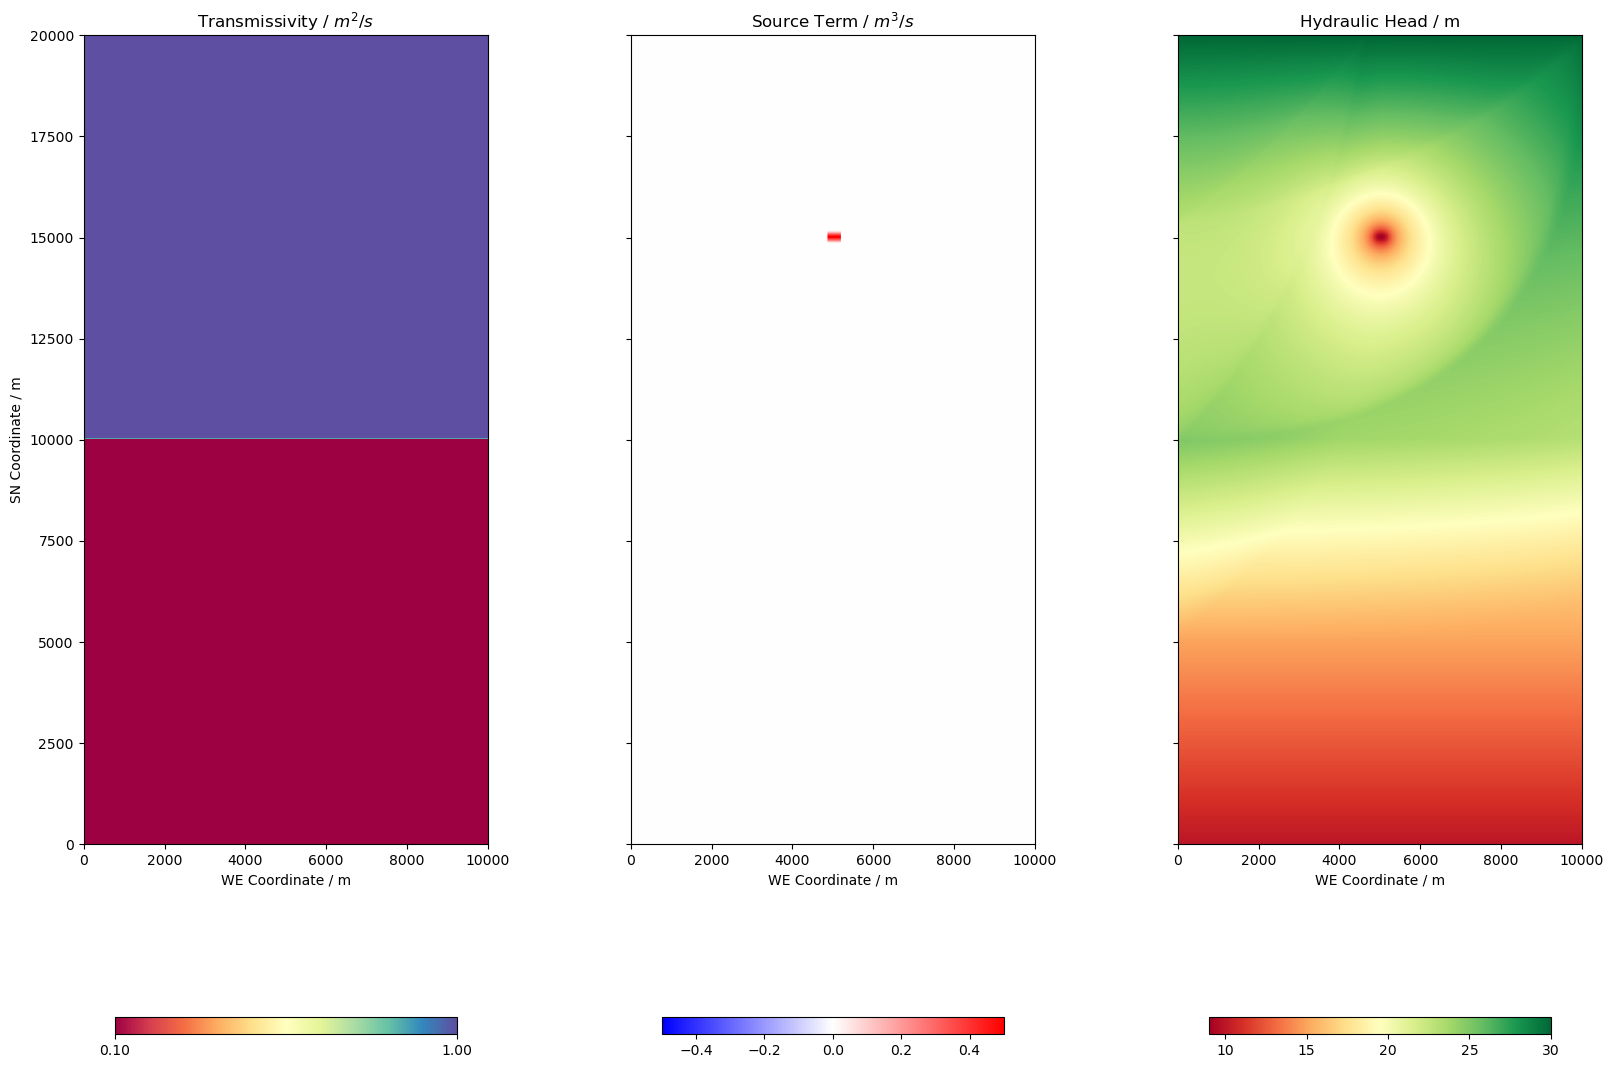

In [29]:
H_img=h_solved.T[::-1,:]
T_img=T.T[::-1,:]
F_img=F.T[::-1,:]
H_img=H_img[:,::-1]
T_img=T_img[:,::-1]
F_img=F_img[:,::-1]
extentimg = [0, Lx, 0, Ly] 

plt.figure()


fig, axs=plt.subplots(1,3, figsize=(20,15),sharey=True)

image= axs[0].imshow(T_img, extent=extentimg, cmap='Spectral')
cbar0=fig.colorbar(image,ax=axs[0],location='bottom', shrink=0.75)
axs[0].set_title('Transmissivity / $m^2/s$')
axs[0].set_ylabel('SN Coordinate / m')
axs[0].set_xlabel('WE Coordinate / m')

locator = ticker.LogLocator(base=10.0, subs=(1.0,), numticks=5)  # Solo potenze di 10
cbar0.locator = locator
cbar0.update_ticks()


image= axs[1].imshow(F_img, extent=extentimg, cmap='bwr', vmax=F.max(), vmin=-F.max())
fig.colorbar(image,ax=axs[1],location='bottom', shrink=0.75)
axs[1].set_title('Source Term / $m^3/s$')
axs[1].set_xlabel('WE Coordinate / m')

image= axs[2].imshow(H_img, extent=extentimg, cmap='RdYlGn') #vmax=h_solved.max(), vmin=h_solved.min())
fig.colorbar(image,ax=axs[2],location='bottom', shrink=0.75)
axs[2].set_title('Hydraulic Head / m')
axs[2].set_xlabel('WE Coordinate / m')
plt.savefig("/home/simone/Scrivania/Physics of the Hydrosphere/Figure/Flow.png",bbox_inches="tight")
plt.show()


In [33]:
#initialize d equal to the initial h

d=np.zeros((Nx+1,Ny+1), float)
index=np.zeros((Nx+1,Ny+1), int)



d[:,0]=10.0
index[:,0]=1
d[:,-1]=30.0
index[:,-1]=1



W_E=np.linspace(10,30, Ny+1)


for i in range(Nx+1):
    d[i,:]=W_E


<Figure size 640x480 with 0 Axes>

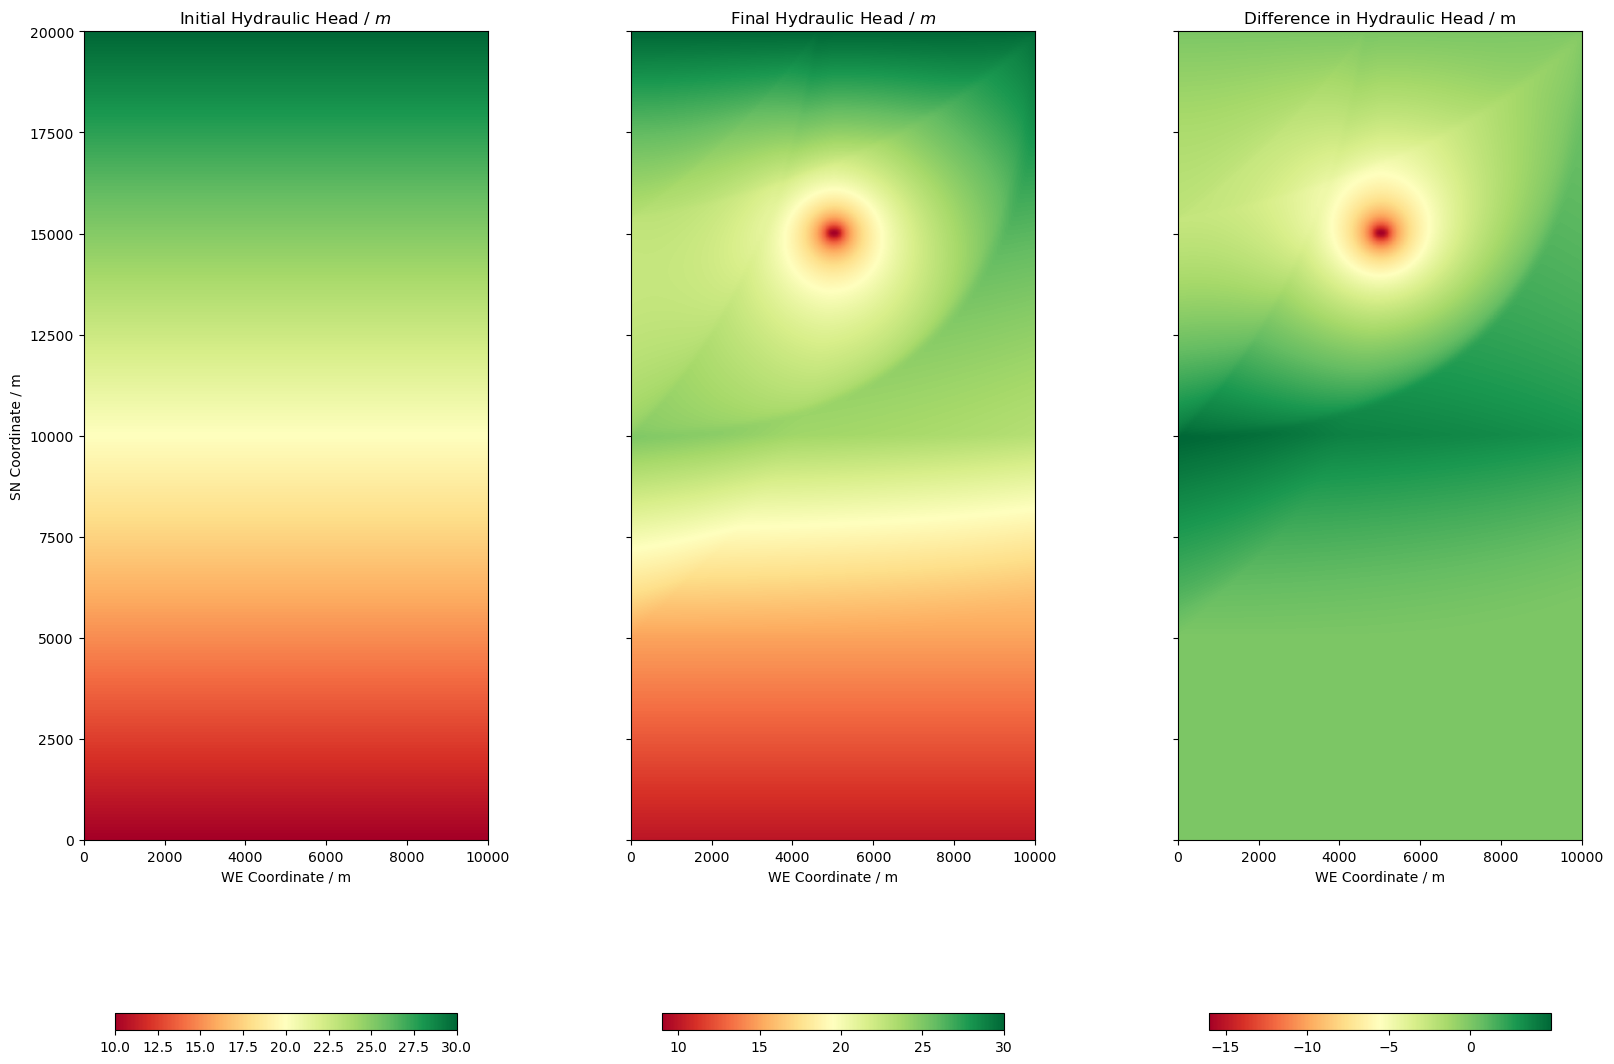

In [34]:
#plottin the difference in h
d_img=d.T[::-1,:]
d_img=d_img[:,::-1]

plt.figure()


fig, axs=plt.subplots(1,3, figsize=(20,15),sharey=True)

image= axs[0].imshow(d_img, extent=extentimg, cmap='RdYlGn')
fig.colorbar(image,ax=axs[0],location='bottom', shrink=0.75)
axs[0].set_title('Initial Hydraulic Head / $m$')
axs[0].set_ylabel('SN Coordinate / m')
axs[0].set_xlabel('WE Coordinate / m')




image= axs[1].imshow(H_img, extent=extentimg, cmap='RdYlGn')
fig.colorbar(image,ax=axs[1],location='bottom', shrink=0.75)
axs[1].set_title('Final Hydraulic Head / $m$')
axs[1].set_xlabel('WE Coordinate / m')

image= axs[2].imshow(H_img-d_img, extent=extentimg, cmap='RdYlGn') #vmax=h_solved.max(), vmin=h_solved.min())
fig.colorbar(image,ax=axs[2],location='bottom', shrink=0.75)
axs[2].set_title('Difference in Hydraulic Head / m')
axs[2].set_xlabel('WE Coordinate / m')
plt.savefig("/home/simone/Scrivania/Physics of the Hydrosphere/Figure/difference.png",bbox_inches="tight")
plt.show()

In [41]:
Difference=H_img-d_img

Difference[Difference>-7]=0

In [56]:
#finding the location of the minimum

for i in range(Ny+1):
    for j in range(Nx+1):
        if Difference[i,j]==Difference.min():
            x=i
            y=j
            

In [61]:
#finding the spacial extention of the circle
dr=0
dl=0
du=0
dd=0

while Difference[x+dr,y] !=0:
                dr+=1
while Difference[x-dl,y] !=0:
                dl+=1
while Difference[x,y+du] !=0:
                du+=1
while Difference[x,y-dd] !=0:
                dd+=1

radiusdr=dr*Dx
radiusdl=dl*Dx
radiusdu=du*Dy
radiusdd=du*Dy

797.3421926910298 963.4551495016611 865.22462562396 865.22462562396
